In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_balanced_tp(supply, demand, costs, penalties = None):
    total_supply = sum(supply)
    total_demand = sum(demand)
    
    if total_supply < total_demand:
        if penalties is None:
            raise Exception('Supply less than demand, penalties required')
        new_supply = supply + [total_demand - total_supply]
        new_costs = costs + [penalties]
        return new_supply, demand, new_costs
    if total_supply > total_demand:
        new_demand = demand + [total_supply - total_demand]
        new_costs = costs + [[0 for _ in demand]]
        return supply, new_demand, new_costs
    return supply, demand, costs



def north_west_corner(supply, demand):
    supply_copy = supply.copy()
    demand_copy = demand.copy()
    i = 0
    j = 0
    bfs = []
    while len(bfs) < len(supply) + len(demand) - 1:
        s = supply_copy[i]
        d = demand_copy[j]
        v = min(s, d)
        supply_copy[i] -= v
        demand_copy[j] -= v
        bfs.append(((i, j), v))
        if supply_copy[i] == 0 and i < len(supply) - 1:
            i += 1
        elif demand_copy[j] == 0 and j < len(demand) - 1:
            j += 1
    return bfs


def get_us_and_vs(bfs, costs):
    us = [None] * len(costs)
    vs = [None] * len(costs[0])
    us[0] = 0
    bfs_copy = bfs.copy()
    while len(bfs_copy) > 0:
        for index, bv in enumerate(bfs_copy):
            i, j = bv[0]
            if us[i] is None and vs[j] is None: continue
                
            cost = costs[i][j]
            if us[i] is None:
                us[i] = cost - vs[j]
            else: 
                vs[j] = cost - us[i]
            bfs_copy.pop(index)
            break
            
    return us, vs      

def get_ws(bfs, costs, us, vs):
    ws = []
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            non_basic = all([p[0] != i or p[1] != j for p, v in bfs])
            if non_basic:
                ws.append(((i, j), us[i] + vs[j] - cost))
    
    return ws

def can_be_improved(ws):
    for p, v in ws:
        if v > 0: return True
    return False

def get_entering_variable_position(ws):
    ws_copy = ws.copy()
    ws_copy.sort(key=lambda w: w[1])
    return ws_copy[-1][0]

def get_possible_next_nodes(loop, not_visited):
    last_node = loop[-1]
    nodes_in_row = [n for n in not_visited if n[0] == last_node[0]]
    nodes_in_column = [n for n in not_visited if n[1] == last_node[1]]
    if len(loop) < 2:
        return nodes_in_row + nodes_in_column
    else:
        prev_node = loop[-2]
        row_move = prev_node[0] == last_node[0]
        if row_move: return nodes_in_column
        return nodes_in_row

def get_loop(bv_positions, ev_position):
    def inner(loop):
        if len(loop) > 3:
            can_be_closed = len(get_possible_next_nodes(loop, [ev_position])) == 1
            if can_be_closed: return loop
        
        not_visited = list(set(bv_positions) - set(loop))
        possible_next_nodes = get_possible_next_nodes(loop, not_visited)
        for next_node in possible_next_nodes:
            new_loop = inner(loop + [next_node])
            if new_loop: return new_loop
    
    return inner([ev_position])

def loop_pivoting(bfs, loop):
    even_cells = loop[0::2]
    odd_cells = loop[1::2]
    get_bv = lambda pos: next(v for p, v in bfs if p == pos)
    leaving_position = sorted(odd_cells, key=get_bv)[0]
    leaving_value = get_bv(leaving_position)
    
    new_bfs = []
    for p, v in [bv for bv in bfs if bv[0] != leaving_position] + [(loop[0], 0)]:
        if p in even_cells:
            v += leaving_value
        elif p in odd_cells:
            v -= leaving_value
        new_bfs.append((p, v))
        
    return new_bfs

def transportation_simplex_method(supply, demand, costs, penalties = None):
    balanced_supply, balanced_demand, balanced_costs = get_balanced_tp(
        supply, demand, costs
    )
    def inner(bfs):
        us, vs = get_us_and_vs(bfs, balanced_costs)
        ws = get_ws(bfs, balanced_costs, us, vs)
        if can_be_improved(ws):
            ev_position = get_entering_variable_position(ws)
            loop = get_loop([p for p, v in bfs], ev_position)
            return inner(loop_pivoting(bfs, loop))
        return bfs
    
    basic_variables = inner(north_west_corner(balanced_supply, balanced_demand))
    solution = np.zeros((len(costs), len(costs[0])))
    for (i, j), v in basic_variables:
        solution[i][j] = v

    return solution

def get_total_cost(costs, solution):
    total_cost = 0
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            total_cost += cost * solution[i][j]
    return total_cost

def transportation(supply, demand, costs, penalties=None):
    solution = transportation_simplex_method(supply, demand, costs, penalties)
    total_cost = get_total_cost(costs, solution)
    print("Optimal Solution:\n")
    print(solution)
    print("\nTotal Cost:", total_cost)
    print("\n")
    fig, ax = plt.subplots()
    im = ax.imshow(costs, cmap='Greys', interpolation='nearest', origin='upper')
    for i in range(solution.shape[0]):
        for j in range(solution.shape[1]):
            if solution[i, j] > 0:
                plt.text(j, i, f'{solution[i, j]}', color='red', ha='center', va='center', fontsize=12)
            else:
                plt.text(j, i, f'{solution[i, j]}', color='blue', ha='center', va='center', fontsize=12)

    for i, supply_value in enumerate(supply):
        plt.text(solution.shape[1], i, f' {supply_value}', color='green', ha='center', va='center', fontsize=12)

    for j, demand_value in enumerate(demand):
        plt.text(j, solution.shape[0], f' {demand_value}', color='orange', ha='center', va='center', fontsize=12)

    plt.xlabel('Consumers')
    plt.ylabel('Suppliers')
    plt.title('Transportation Problem Solution')

    plt.axis('off')

    plt.show()

Optimal Solution:

[[30.  0.  0.  0.  0.]
 [ 0.  0. 40. 20. 10.]
 [10. 30.  0.  0. 10.]]

Total Cost: 710.0




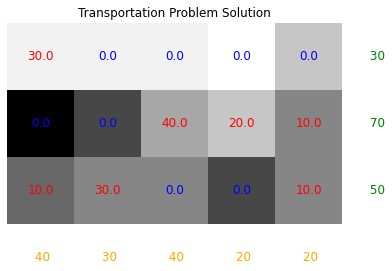

In [2]:
cost_matrix = [
    [2, 2, 2, 1, 4],
    [10, 8, 5, 4, 6],
    [7, 6, 6, 8, 6]
]
supply = [30, 70, 50]
demand = [40, 30, 40, 20, 20]
transportation(supply, demand, cost_matrix)

In [1]:
cost_matrix = [
    [4,6,8],
    [5,4,3],
    
]
supply = [30, 50]
demand = [20, 40, 20]
transportation(supply, demand, cost_matrix)

NameError: name 'transportation' is not defined

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_balanced_tp(supply, demand, costs, penalties = None):
    total_supply = sum(supply)
    total_demand = sum(demand)
    
    if total_supply < total_demand:
        if penalties is None:
            raise Exception('Supply less than demand, penalties required')
        new_supply = supply + [total_demand - total_supply]
        new_costs = costs + [penalties]
        return new_supply, demand, new_costs
    if total_supply > total_demand:
        new_demand = demand + [total_supply - total_demand]
        new_costs = costs + [[0 for _ in demand]]
        return supply, new_demand, new_costs
    return supply, demand, costs



def north_west_corner(supply, demand):
    supply_copy = supply.copy()
    demand_copy = demand.copy()
    i = 0
    j = 0
    bfs = []
    while len(bfs) < len(supply) + len(demand) - 1:
        s = supply_copy[i]
        d = demand_copy[j]
        v = min(s, d)
        supply_copy[i] -= v
        demand_copy[j] -= v
        bfs.append(((i, j), v))
        if supply_copy[i] == 0 and i < len(supply) - 1:
            i += 1
        elif demand_copy[j] == 0 and j < len(demand) - 1:
            j += 1
    return bfs


def get_us_and_vs(bfs, costs):
    us = [None] * len(costs)
    vs = [None] * len(costs[0])
    us[0] = 0
    bfs_copy = bfs.copy()
    while len(bfs_copy) > 0:
        for index, bv in enumerate(bfs_copy):
            i, j = bv[0]
            if us[i] is None and vs[j] is None: continue
                
            cost = costs[i][j]
            if us[i] is None:
                us[i] = cost - vs[j]
            else: 
                vs[j] = cost - us[i]
            bfs_copy.pop(index)
            break
            
    return us, vs      

def get_ws(bfs, costs, us, vs):
    ws = []
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            non_basic = all([p[0] != i or p[1] != j for p, v in bfs])
            if non_basic:
                ws.append(((i, j), us[i] + vs[j] - cost))
    
    return ws

def can_be_improved(ws):
    for p, v in ws:
        if v > 0: return True
    return False

def get_entering_variable_position(ws):
    ws_copy = ws.copy()
    ws_copy.sort(key=lambda w: w[1])
    return ws_copy[-1][0]

def get_possible_next_nodes(loop, not_visited):
    last_node = loop[-1]
    nodes_in_row = [n for n in not_visited if n[0] == last_node[0]]
    nodes_in_column = [n for n in not_visited if n[1] == last_node[1]]
    if len(loop) < 2:
        return nodes_in_row + nodes_in_column
    else:
        prev_node = loop[-2]
        row_move = prev_node[0] == last_node[0]
        if row_move: return nodes_in_column
        return nodes_in_row

def get_loop(bv_positions, ev_position):
    def inner(loop):
        if len(loop) > 3:
            can_be_closed = len(get_possible_next_nodes(loop, [ev_position])) == 1
            if can_be_closed: return loop
        
        not_visited = list(set(bv_positions) - set(loop))
        possible_next_nodes = get_possible_next_nodes(loop, not_visited)
        for next_node in possible_next_nodes:
            new_loop = inner(loop + [next_node])
            if new_loop: return new_loop
    
    return inner([ev_position])

def loop_pivoting(bfs, loop):
    even_cells = loop[0::2]
    odd_cells = loop[1::2]
    get_bv = lambda pos: next(v for p, v in bfs if p == pos)
    leaving_position = sorted(odd_cells, key=get_bv)[0]
    leaving_value = get_bv(leaving_position)
    
    new_bfs = []
    for p, v in [bv for bv in bfs if bv[0] != leaving_position] + [(loop[0], 0)]:
        if p in even_cells:
            v += leaving_value
        elif p in odd_cells:
            v -= leaving_value
        new_bfs.append((p, v))
        
    return new_bfs

def transportation_simplex_method(supply, demand, costs, penalties = None):
    balanced_supply, balanced_demand, balanced_costs = get_balanced_tp(
        supply, demand, costs
    )
    def inner(bfs):
        us, vs = get_us_and_vs(bfs, balanced_costs)
        ws = get_ws(bfs, balanced_costs, us, vs)
        if can_be_improved(ws):
            ev_position = get_entering_variable_position(ws)
            loop = get_loop([p for p, v in bfs], ev_position)
            return inner(loop_pivoting(bfs, loop))
        return bfs
    
    basic_variables = inner(north_west_corner(balanced_supply, balanced_demand))
    solution = np.zeros((len(costs), len(costs[0])))
    for (i, j), v in basic_variables:
        solution[i][j] = v

    return solution

def get_total_cost(costs, solution):
    total_cost = 0
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            total_cost += cost * solution[i][j]
    return total_cost

def transportation(supply, demand, costs, penalties=None):
    solution = transportation_simplex_method(supply, demand, costs, penalties)
    total_cost = get_total_cost(costs, solution)
    print("Optimal Solution:\n")
    print(solution)
    print("\nTotal Cost:", total_cost)
    print("\n")
    fig, ax = plt.subplots()
    im = ax.imshow(costs, cmap='Greys', interpolation='nearest', origin='upper')
    for i in range(solution.shape[0]):
        for j in range(solution.shape[1]):
            if solution[i, j] > 0:
                plt.text(j, i, f'{solution[i, j]}', color='red', ha='center', va='center', fontsize=12)
            else:
                plt.text(j, i, f'{solution[i, j]}', color='blue', ha='center', va='center', fontsize=12)

    for i, supply_value in enumerate(supply):
        plt.text(solution.shape[1], i, f' {supply_value}', color='green', ha='center', va='center', fontsize=12)

    for j, demand_value in enumerate(demand):
        plt.text(j, solution.shape[0], f' {demand_value}', color='orange', ha='center', va='center', fontsize=12)

    plt.xlabel('Consumers')
    plt.ylabel('Suppliers')
    plt.title('Transportation Problem Solution')

    plt.axis('off')

    plt.show()import numpy as np
import matplotlib.pyplot as plt

def get_balanced_tp(supply, demand, costs, penalties = None):
    total_supply = sum(supply)
    total_demand = sum(demand)
    
    if total_supply < total_demand:
        if penalties is None:
            raise Exception('Supply less than demand, penalties required')
        new_supply = supply + [total_demand - total_supply]
        new_costs = costs + [penalties]
        return new_supply, demand, new_costs
    if total_supply > total_demand:
        new_demand = demand + [total_supply - total_demand]
        new_costs = costs + [[0 for _ in demand]]
        return supply, new_demand, new_costs
    return supply, demand, costs



def north_west_corner(supply, demand):
    supply_copy = supply.copy()
    demand_copy = demand.copy()
    i = 0
    j = 0
    bfs = []
    while len(bfs) < len(supply) + len(demand) - 1:
        s = supply_copy[i]
        d = demand_copy[j]
        v = min(s, d)
        supply_copy[i] -= v
        demand_copy[j] -= v
        bfs.append(((i, j), v))
        if supply_copy[i] == 0 and i < len(supply) - 1:
            i += 1
        elif demand_copy[j] == 0 and j < len(demand) - 1:
            j += 1
    return bfs


def get_us_and_vs(bfs, costs):
    us = [None] * len(costs)
    vs = [None] * len(costs[0])
    us[0] = 0
    bfs_copy = bfs.copy()
    while len(bfs_copy) > 0:
        for index, bv in enumerate(bfs_copy):
            i, j = bv[0]
            if us[i] is None and vs[j] is None: continue
                
            cost = costs[i][j]
            if us[i] is None:
                us[i] = cost - vs[j]
            else: 
                vs[j] = cost - us[i]
            bfs_copy.pop(index)
            break
            
    return us, vs      

def get_ws(bfs, costs, us, vs):
    ws = []
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            non_basic = all([p[0] != i or p[1] != j for p, v in bfs])
            if non_basic:
                ws.append(((i, j), us[i] + vs[j] - cost))
    
    return ws

def can_be_improved(ws):
    for p, v in ws:
        if v > 0: return True
    return False

def get_entering_variable_position(ws):
    ws_copy = ws.copy()
    ws_copy.sort(key=lambda w: w[1])
    return ws_copy[-1][0]

def get_possible_next_nodes(loop, not_visited):
    last_node = loop[-1]
    nodes_in_row = [n for n in not_visited if n[0] == last_node[0]]
    nodes_in_column = [n for n in not_visited if n[1] == last_node[1]]
    if len(loop) < 2:
        return nodes_in_row + nodes_in_column
    else:
        prev_node = loop[-2]
        row_move = prev_node[0] == last_node[0]
        if row_move: return nodes_in_column
        return nodes_in_row

def get_loop(bv_positions, ev_position):
    def inner(loop):
        if len(loop) > 3:
            can_be_closed = len(get_possible_next_nodes(loop, [ev_position])) == 1
            if can_be_closed: return loop
        
        not_visited = list(set(bv_positions) - set(loop))
        possible_next_nodes = get_possible_next_nodes(loop, not_visited)
        for next_node in possible_next_nodes:
            new_loop = inner(loop + [next_node])
            if new_loop: return new_loop
    
    return inner([ev_position])

def loop_pivoting(bfs, loop):
    even_cells = loop[0::2]
    odd_cells = loop[1::2]
    get_bv = lambda pos: next(v for p, v in bfs if p == pos)
    leaving_position = sorted(odd_cells, key=get_bv)[0]
    leaving_value = get_bv(leaving_position)
    
    new_bfs = []
    for p, v in [bv for bv in bfs if bv[0] != leaving_position] + [(loop[0], 0)]:
        if p in even_cells:
            v += leaving_value
        elif p in odd_cells:
            v -= leaving_value
        new_bfs.append((p, v))
        
    return new_bfs

def transportation_simplex_method(supply, demand, costs, penalties = None):
    balanced_supply, balanced_demand, balanced_costs = get_balanced_tp(
        supply, demand, costs
    )
    def inner(bfs):
        us, vs = get_us_and_vs(bfs, balanced_costs)
        ws = get_ws(bfs, balanced_costs, us, vs)
        if can_be_improved(ws):
            ev_position = get_entering_variable_position(ws)
            loop = get_loop([p for p, v in bfs], ev_position)
            return inner(loop_pivoting(bfs, loop))
        return bfs
    
    basic_variables = inner(north_west_corner(balanced_supply, balanced_demand))
    solution = np.zeros((len(costs), len(costs[0])))
    for (i, j), v in basic_variables:
        solution[i][j] = v

    return solution

def get_total_cost(costs, solution):
    total_cost = 0
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            total_cost += cost * solution[i][j]
    return total_cost

def transportation(supply, demand, costs, penalties=None):
    solution = transportation_simplex_method(supply, demand, costs, penalties)
    total_cost = get_total_cost(costs, solution)
    print("Optimal Solution:\n")
    print(solution)
    print("\nTotal Cost:", total_cost)
    print("\n")
    fig, ax = plt.subplots()
    im = ax.imshow(costs, cmap='Greys', interpolation='nearest', origin='upper')
    for i in range(solution.shape[0]):
        for j in range(solution.shape[1]):
            if solution[i, j] > 0:
                plt.text(j, i, f'{solution[i, j]}', color='red', ha='center', va='center', fontsize=12)
            else:
                plt.text(j, i, f'{solution[i, j]}', color='blue', ha='center', va='center', fontsize=12)

    for i, supply_value in enumerate(supply):
        plt.text(solution.shape[1], i, f' {supply_value}', color='green', ha='center', va='center', fontsize=12)

    for j, demand_value in enumerate(demand):
        plt.text(j, solution.shape[0], f' {demand_value}', color='orange', ha='center', va='center', fontsize=12)

    plt.xlabel('Consumers')
    plt.ylabel('Suppliers')
    plt.title('Transportation Problem Solution')

    plt.axis('off')

    plt.show()

SyntaxError: invalid syntax (<ipython-input-2-883a7e46a2c4>, line 180)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def get_balanced_tp(supply, demand, costs, penalties = None):
    total_supply = sum(supply)
    total_demand = sum(demand)
    
    if total_supply < total_demand:
        if penalties is None:
            raise Exception('Supply less than demand, penalties required')
        new_supply = supply + [total_demand - total_supply]
        new_costs = costs + [penalties]
        return new_supply, demand, new_costs
    if total_supply > total_demand:
        new_demand = demand + [total_supply - total_demand]
        new_costs = costs + [[0 for _ in demand]]
        return supply, new_demand, new_costs
    return supply, demand, costs



def north_west_corner(supply, demand):
    supply_copy = supply.copy()
    demand_copy = demand.copy()
    i = 0
    j = 0
    bfs = []
    while len(bfs) < len(supply) + len(demand) - 1:
        s = supply_copy[i]
        d = demand_copy[j]
        v = min(s, d)
        supply_copy[i] -= v
        demand_copy[j] -= v
        bfs.append(((i, j), v))
        if supply_copy[i] == 0 and i < len(supply) - 1:
            i += 1
        elif demand_copy[j] == 0 and j < len(demand) - 1:
            j += 1
    return bfs


def get_us_and_vs(bfs, costs):
    us = [None] * len(costs)
    vs = [None] * len(costs[0])
    us[0] = 0
    bfs_copy = bfs.copy()
    while len(bfs_copy) > 0:
        for index, bv in enumerate(bfs_copy):
            i, j = bv[0]
            if us[i] is None and vs[j] is None: continue
                
            cost = costs[i][j]
            if us[i] is None:
                us[i] = cost - vs[j]
            else: 
                vs[j] = cost - us[i]
            bfs_copy.pop(index)
            break
            
    return us, vs      

def get_ws(bfs, costs, us, vs):
    ws = []
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            non_basic = all([p[0] != i or p[1] != j for p, v in bfs])
            if non_basic:
                ws.append(((i, j), us[i] + vs[j] - cost))
    
    return ws

def can_be_improved(ws):
    for p, v in ws:
        if v > 0: return True
    return False

def get_entering_variable_position(ws):
    ws_copy = ws.copy()
    ws_copy.sort(key=lambda w: w[1])
    return ws_copy[-1][0]

def get_possible_next_nodes(loop, not_visited):
    last_node = loop[-1]
    nodes_in_row = [n for n in not_visited if n[0] == last_node[0]]
    nodes_in_column = [n for n in not_visited if n[1] == last_node[1]]
    if len(loop) < 2:
        return nodes_in_row + nodes_in_column
    else:
        prev_node = loop[-2]
        row_move = prev_node[0] == last_node[0]
        if row_move: return nodes_in_column
        return nodes_in_row

def get_loop(bv_positions, ev_position):
    def inner(loop):
        if len(loop) > 3:
            can_be_closed = len(get_possible_next_nodes(loop, [ev_position])) == 1
            if can_be_closed: return loop
        
        not_visited = list(set(bv_positions) - set(loop))
        possible_next_nodes = get_possible_next_nodes(loop, not_visited)
        for next_node in possible_next_nodes:
            new_loop = inner(loop + [next_node])
            if new_loop: return new_loop
    
    return inner([ev_position])

def loop_pivoting(bfs, loop):
    even_cells = loop[0::2]
    odd_cells = loop[1::2]
    get_bv = lambda pos: next(v for p, v in bfs if p == pos)
    leaving_position = sorted(odd_cells, key=get_bv)[0]
    leaving_value = get_bv(leaving_position)
    
    new_bfs = []
    for p, v in [bv for bv in bfs if bv[0] != leaving_position] + [(loop[0], 0)]:
        if p in even_cells:
            v += leaving_value
        elif p in odd_cells:
            v -= leaving_value
        new_bfs.append((p, v))
        
    return new_bfs

def transportation_simplex_method(supply, demand, costs, penalties = None):
    balanced_supply, balanced_demand, balanced_costs = get_balanced_tp(
        supply, demand, costs
    )
    def inner(bfs):
        us, vs = get_us_and_vs(bfs, balanced_costs)
        ws = get_ws(bfs, balanced_costs, us, vs)
        if can_be_improved(ws):
            ev_position = get_entering_variable_position(ws)
            loop = get_loop([p for p, v in bfs], ev_position)
            return inner(loop_pivoting(bfs, loop))
        return bfs
    
    basic_variables = inner(north_west_corner(balanced_supply, balanced_demand))
    solution = np.zeros((len(costs), len(costs[0])))
    for (i, j), v in basic_variables:
        solution[i][j] = v

    return solution

def get_total_cost(costs, solution):
    total_cost = 0
    for i, row in enumerate(costs):
        for j, cost in enumerate(row):
            total_cost += cost * solution[i][j]
    return total_cost

def transportation(supply, demand, costs, penalties=None):
    solution = transportation_simplex_method(supply, demand, costs, penalties)
    total_cost = get_total_cost(costs, solution)
    print("Optimal Solution:\n")
    print(solution)
    print("\nTotal Cost:", total_cost)
    print("\n")
    fig, ax = plt.subplots()
    im = ax.imshow(costs, cmap='Greys', interpolation='nearest', origin='upper')
    for i in range(solution.shape[0]):
        for j in range(solution.shape[1]):
            if solution[i, j] > 0:
                plt.text(j, i, f'{solution[i, j]}', color='red', ha='center', va='center', fontsize=12)
            else:
                plt.text(j, i, f'{solution[i, j]}', color='blue', ha='center', va='center', fontsize=12)

    for i, supply_value in enumerate(supply):
        plt.text(solution.shape[1], i, f' {supply_value}', color='green', ha='center', va='center', fontsize=12)

    for j, demand_value in enumerate(demand):
        plt.text(j, solution.shape[0], f' {demand_value}', color='orange', ha='center', va='center', fontsize=12)

    plt.xlabel('Consumers')
    plt.ylabel('Suppliers')
    plt.title('Transportation Problem Solution')

    plt.axis('off')

    plt.show()

Optimal Solution:

[[20. 10.  0.]
 [ 0. 30. 20.]]

Total Cost: 320.0




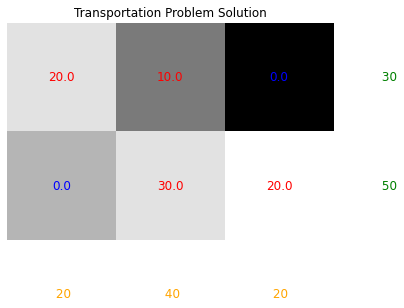

In [4]:
cost_matrix = [
    [4,6,8],
    [5,4,3],
    
]
supply = [30, 50]
demand = [20, 40, 20]
transportation(supply, demand, cost_matrix)

Optimal Solution:

[[30.  0.  0. 20.]
 [ 0. 40. 20.  0.]
 [ 0.  0. 30. 40.]]

Total Cost: 860.0




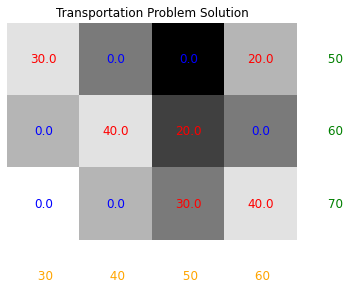

In [5]:
cost_matrix = [
    [4, 6, 8, 5],
    [5, 4, 7, 6],
    [3, 5, 6, 4]
]
supply = [50, 60, 70]
demand = [30, 40, 50, 60]
transportation(supply, demand, cost_matrix)
